In [1]:
import os
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
"""
Data Folder for YOLOv5 tests
"""
data_folder = "./data-yolo"


### Get Data

In [3]:
def filter_images_with_labels(image_files, data_folder):
    """Filters image files to include only those with corresponding label files."""
    valid_images = []
    for img_file in image_files:
        label_file = img_file.replace(".jpg", ".txt")
        if os.path.exists(os.path.join(data_folder, label_file)):
            valid_images.append((img_file, label_file))
    return valid_images

image_files = [f for f in os.listdir(data_folder) if f.endswith(".jpg")]
filtered_images = filter_images_with_labels(image_files, data_folder)

### Data Analysis

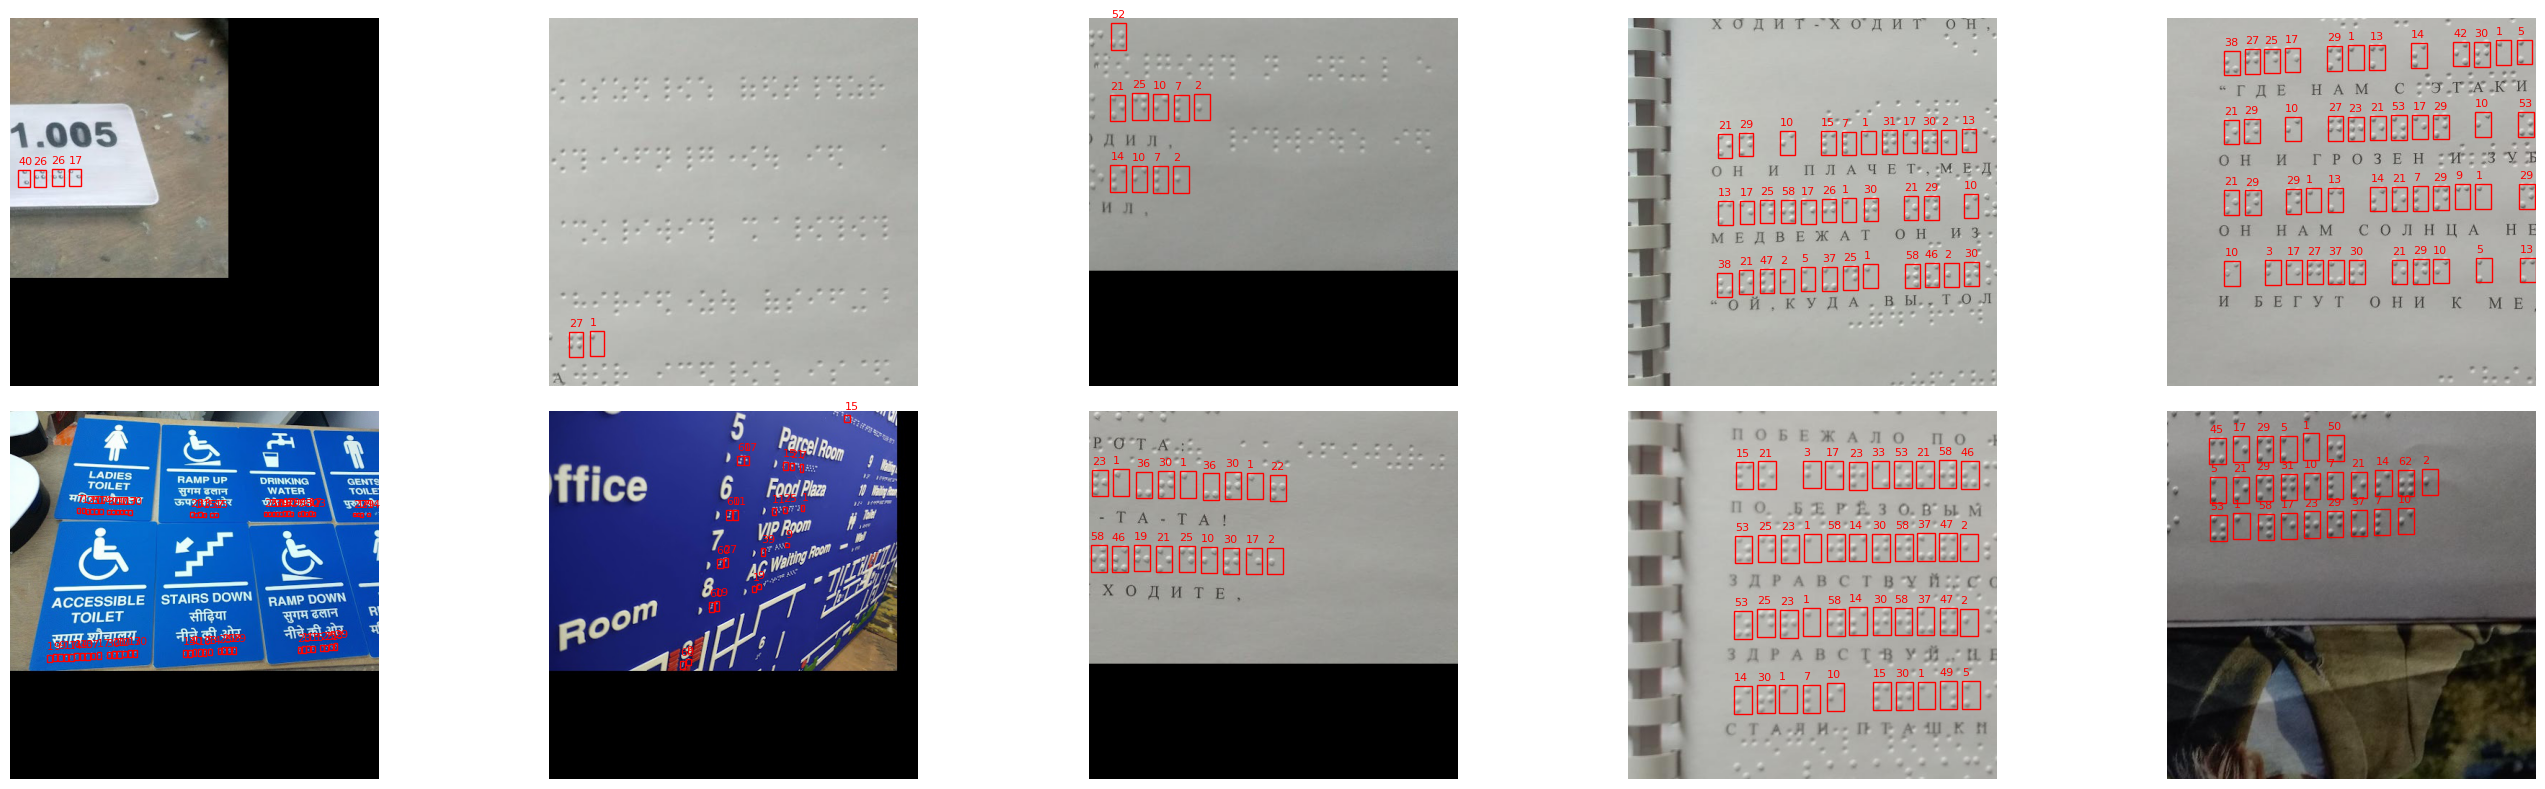

In [4]:
random_images = random.sample(filtered_images, min(10, len(filtered_images)))

def plot_annotated_images(image_files):
    fig, axs = plt.subplots(2, 5, figsize=(28, 8))
    axs = axs.flatten()

    for idx, (img_file, lbl_file) in enumerate(image_files):
        img_path = os.path.join(data_folder, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        height, width, _ = img.shape
        
        with open(os.path.join(data_folder, lbl_file), "r") as f:
            boxes = f.readlines()
        
        axs[idx].imshow(img)
        for box in boxes:
            class_id, x_center, y_center, box_width, box_height = map(float, box.strip().split())
            x_center *= width
            y_center *= height
            box_width *= width
            box_height *= height
            x_min = x_center - box_width / 2
            y_min = y_center - box_height / 2
            
            axs[idx].add_patch(plt.Rectangle((x_min, y_min), box_width, box_height, edgecolor='red', facecolor='none'))
            axs[idx].text(x_min, y_min - 5, f"{int(class_id) + 1}", color='red', fontsize=8, verticalalignment='bottom')

        axs[idx].axis("off")

    for j in range(idx + 1, 10):
        axs[j].axis("off")

    plt.tight_layout()
    plt.show()

plot_annotated_images(random_images)


In [5]:
freq_label = {}

for idx, (_, lbl_file) in enumerate(filtered_images):
    with open(os.path.join(data_folder, lbl_file), 'r') as label:
        labels = label.readlines()
        
    labels = [int(l.strip().split()[0]) for l in labels]
    for label in labels:
        if label in freq_label:
            freq_label[label] += 1
        else:
            freq_label[label] = 1

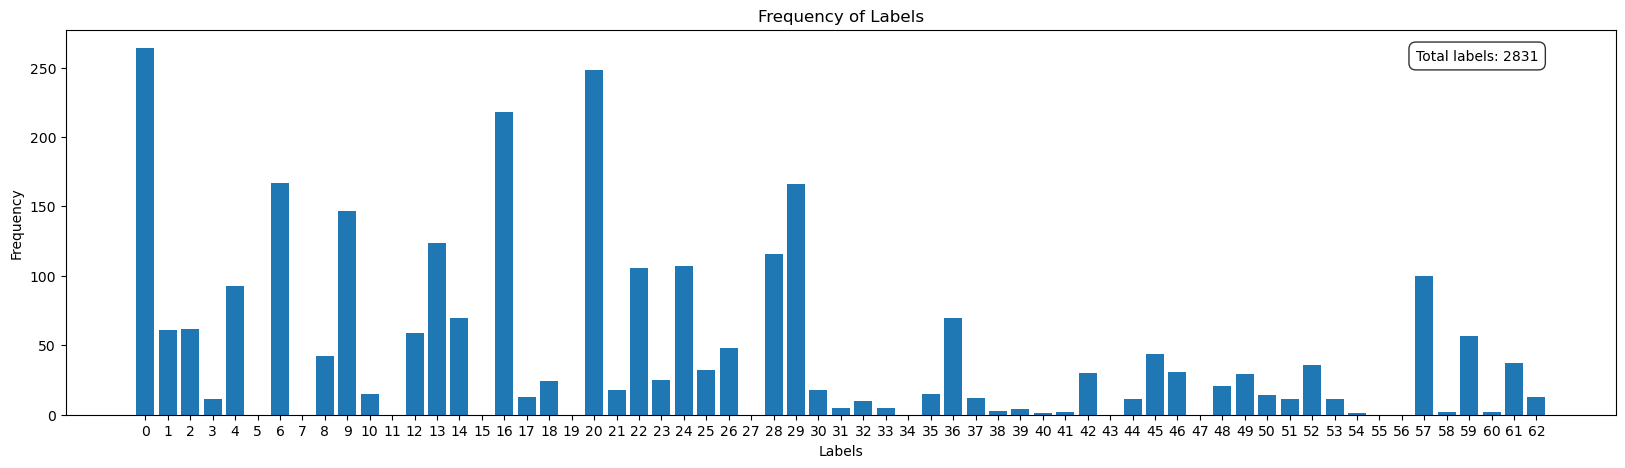

In [6]:
from typing import Dict

def plot_freq_map(freq_map:Dict, x_label:str='Labels', y_label:str='Frequency', title:str='Frequency of Labels'):
    keys = sorted(freq_map.keys())
    values = [freq_map[key] for key in keys]
    total = sum(values)
    
    plt.figure(figsize=(20, 5))
    plt.bar(keys, values)
    plt.xticks(range(min(keys), max(keys) + 1))
    plt.gca().text(0.95, 0.95, f'Total labels: {total}', ha='right', va='top', transform=plt.gca().transAxes,
                   bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', boxstyle='round,pad=0.5'))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    
    plt.show()

plot_freq_map(freq_map=freq_label)

### YOLOv5 Only

<img src="yolov5-model-structure.avif" alt="YOLOv5 Model Structure" width="50%">

train, test, validation split: 60, 20, 20

In [7]:
from ultralytics import YOLO
import shutil
from sklearn.model_selection import train_test_split

NUM_EPOCHS_YOLO = 1
BATCH_SIZE_YOLO = 18

yolo_data_folder = './yolo-data'
os.makedirs(yolo_data_folder, exist_ok=True)

model = YOLO('yolov5s.pt')

PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



In [8]:
train_images, temp_images = train_test_split(filtered_images, test_size=0.4, random_state=42)
val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

os.makedirs(os.path.join(yolo_data_folder, 'train', 'images'), exist_ok=True)
os.makedirs(os.path.join(yolo_data_folder, 'train', 'labels'), exist_ok=True)
os.makedirs(os.path.join(yolo_data_folder, 'val', 'images'), exist_ok=True)
os.makedirs(os.path.join(yolo_data_folder, 'val', 'labels'), exist_ok=True)
os.makedirs(os.path.join(yolo_data_folder, 'test', 'images'), exist_ok=True)
os.makedirs(os.path.join(yolo_data_folder, 'test', 'labels'), exist_ok=True)

for img_file, label_file in train_images:
    shutil.copy(os.path.join(data_folder, img_file), os.path.join(yolo_data_folder, 'train', 'images'))
    shutil.copy(os.path.join(data_folder, label_file), os.path.join(yolo_data_folder, 'train', 'labels'))

for img_file, label_file in val_images:
    shutil.copy(os.path.join(data_folder, img_file), os.path.join(yolo_data_folder, 'val', 'images'))
    shutil.copy(os.path.join(data_folder, label_file), os.path.join(yolo_data_folder, 'val', 'labels'))

for img_file, label_file in test_images:
    shutil.copy(os.path.join(data_folder, img_file), os.path.join(yolo_data_folder, 'test', 'images'))
    shutil.copy(os.path.join(data_folder, label_file), os.path.join(yolo_data_folder, 'test', 'labels'))

In [9]:
if os.path.exists('./runs'):
    shutil.rmtree('./runs')
history = model.train(data='yolo.yaml', epochs=NUM_EPOCHS_YOLO, batch=BATCH_SIZE_YOLO)

Ultralytics 8.3.28 🚀 Python-3.12.2 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5931MiB)
engine/trainer: task=detect, mode=train, model=yolov5s.pt, data=yolo.yaml, epochs=1, time=None, patience=100, batch=18, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes

train: Scanning /home/zeenx1popos/Documents/codes/fyb/yolo-data/train/labels.cache... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/home/zeenx1popos/.conda/envs/fybp/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /home/zeenx1popos/Documents/codes/fyb/yolo-data/val/labels.cache... 19 images, 0 backgrounds, 0 corrupt: 100%|██████████| 19/19 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000149, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005625000000000001), 75 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      4.67G        3.3      6.404      2.002         75        640: 100%|██████████| 4/4 [00:01<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

                   all         19        562          0          0          0          0



1 epochs completed in 0.001 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.28 🚀 Python-3.12.2 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5931MiB)
YOLOv5s summary (fused): 193 layers, 9,135,917 parameters, 0 gradients, 24.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]

                   all         19        562          0          0          0          0


Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/train


#### Training and Validation Loss

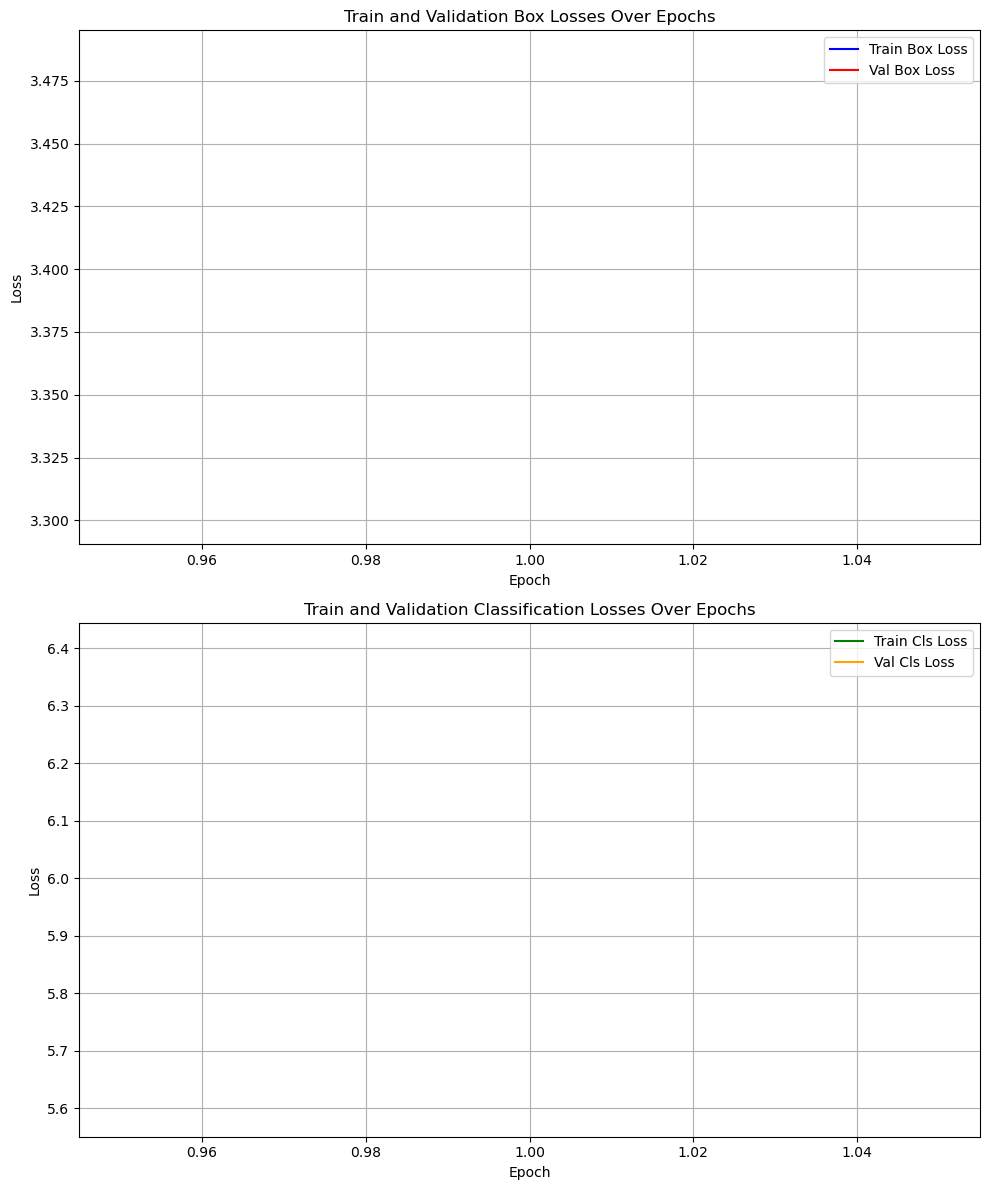

In [10]:
YOLO_RESULTS_FOLDER = './runs/detect/train'

import pandas as pd

df = pd.read_csv(os.path.join(YOLO_RESULTS_FOLDER, 'results.csv'))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

ax1.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss', color='blue')
ax1.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Train and Validation Box Losses Over Epochs')
ax1.legend()
ax1.grid(True)

ax2.plot(df['epoch'], df['train/cls_loss'], label='Train Cls Loss', color='green')
ax2.plot(df['epoch'], df['val/cls_loss'], label='Val Cls Loss', color='orange')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Train and Validation Classification Losses Over Epochs')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()



In [11]:
test_images_path = os.path.join(yolo_data_folder, 'test', 'images')

model_weights = os.path.join(YOLO_RESULTS_FOLDER, 'weights/best.pt')
trained_model = YOLO(model_weights)



image 1/1 /home/zeenx1popos/Documents/codes/fyb/yolo-data/test/images/IMG_20190821_123648.labeled_512_0.jpg: 640x640 (no detections), 6.9ms
Speed: 2.2ms preprocess, 6.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


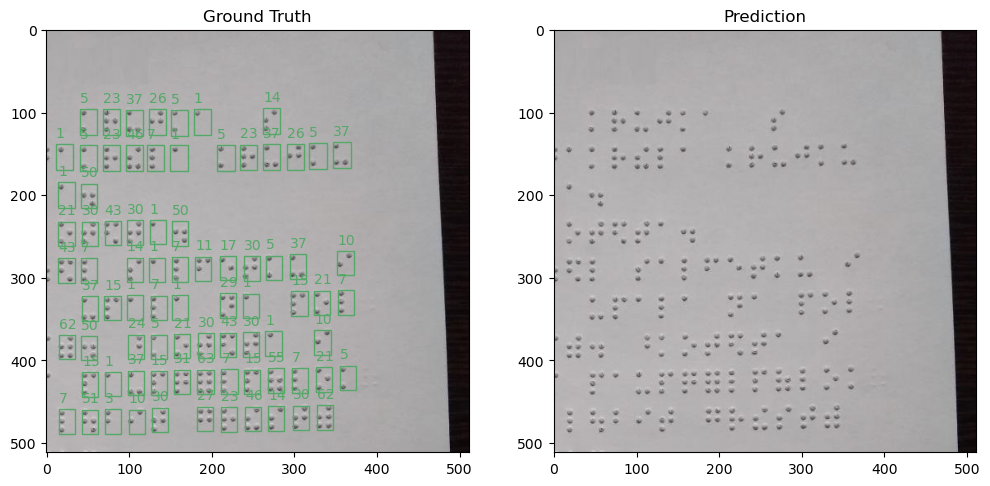


image 1/1 /home/zeenx1popos/Documents/codes/fyb/yolo-data/test/images/IMG_20190715_113010.labeled_512_1024.jpg: 640x640 (no detections), 6.3ms
Speed: 2.2ms preprocess, 6.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


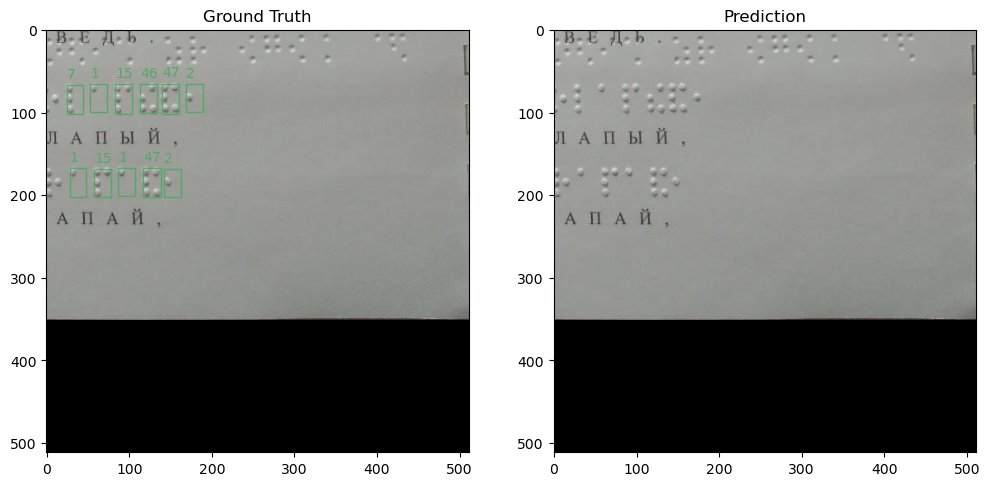


image 1/1 /home/zeenx1popos/Documents/codes/fyb/yolo-data/test/images/IMG_20190715_113010.labeled_512_512.jpg: 640x640 (no detections), 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


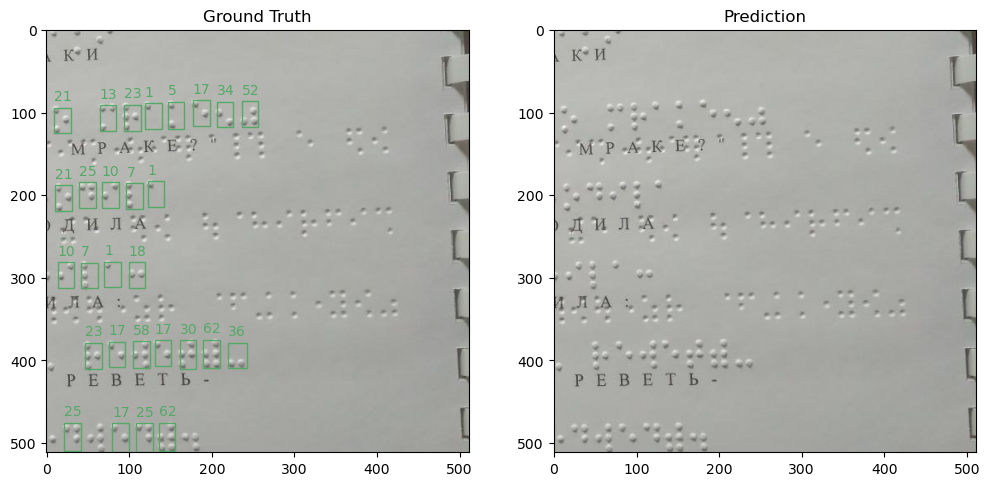


image 1/1 /home/zeenx1popos/Documents/codes/fyb/yolo-data/test/images/IMG-20190315-WA0017_0_0.jpg: 640x640 (no detections), 6.3ms
Speed: 2.3ms preprocess, 6.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


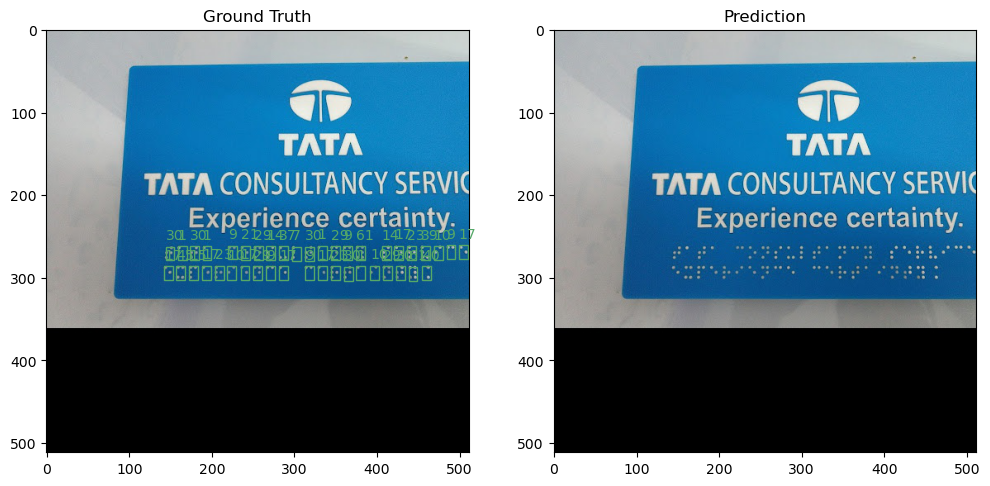


image 1/1 /home/zeenx1popos/Documents/codes/fyb/yolo-data/test/images/IMG-20190420-WA0010_0_0.jpg: 640x640 (no detections), 6.4ms
Speed: 2.6ms preprocess, 6.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


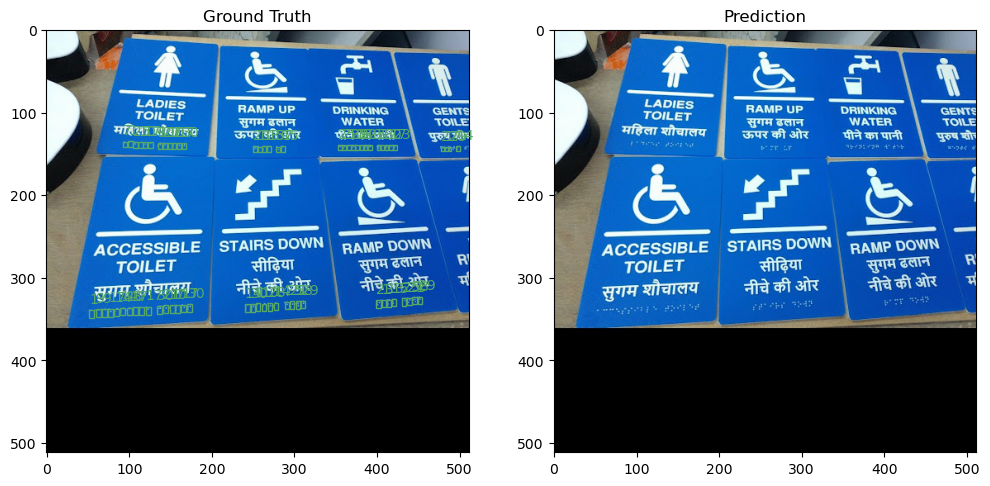

In [12]:
from random import choice

def plot_annotated_images_with_predictions(test_images, trained_model):
    img_file, lbl_file = choice(test_images)
    img_file = os.path.join(yolo_data_folder, 'test', 'images', img_file)
    lbl_file = os.path.join(yolo_data_folder, 'test', 'labels', lbl_file)
    
    img = cv2.imread(img_file)
    
    if img is None:
        print(f"Error: Could not load image {img_file}")
        return
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, _ = img.shape
    
    with open(lbl_file, "r") as f:
        ground_truth_boxes = f.readlines()
    
    results = trained_model(img_file)
    predictions = results[0].boxes.xywh.cpu().numpy()
    confidences = results[0].boxes.conf.cpu().numpy()
    class_ids = results[0].boxes.cls.cpu().numpy()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.imshow(img_rgb)
    ax1.set_title("Ground Truth")
    
    for gt_box in ground_truth_boxes:
        class_id, x_center, y_center, box_width, box_height = map(float, gt_box.strip().split())
        x_center *= width
        y_center *= height
        box_width *= width
        box_height *= height
        x_min = x_center - box_width / 2
        y_min = y_center - box_height / 2
        ax1.add_patch(plt.Rectangle((x_min, y_min), box_width, box_height, edgecolor='g', facecolor='none'))
        ax1.text(x_min, y_min - 5, f"{int(class_id) + 1}", color='g', fontsize=10, verticalalignment='bottom')
    
    ax2.imshow(img_rgb)
    ax2.set_title("Prediction")
    
    for pred_box, confidence, class_id in zip(predictions, confidences, class_ids):
        x_center, y_center, width_pred, height_pred = pred_box
        
        x_min = x_center - width_pred / 2
        y_min = y_center - height_pred / 2
        
        ax2.add_patch(plt.Rectangle((x_min, y_min), width_pred, height_pred, edgecolor='r', facecolor='none'))
        ax2.text(x_min, y_min - 5, f"{int(class_id) + 1}\n({confidence:.2f})", color='r', fontsize=8, verticalalignment='bottom')
    
    plt.show()

    
for _ in range(5):
    plot_annotated_images_with_predictions(test_images, trained_model)

In [13]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

def iou_score(box_a, box_b):
    """Calculate Intersection over Union (IoU) between two bounding boxes."""
    x_min_a, y_min_a, width_a, height_a = box_a
    x_min_b, y_min_b, width_b, height_b = box_b

    x_max_a, y_max_a = x_min_a + width_a, y_min_a + height_a
    x_max_b, y_max_b = x_min_b + width_b, y_min_b + height_b

    inter_x_min = max(x_min_a, x_min_b)
    inter_y_min = max(y_min_a, y_min_b)
    inter_x_max = min(x_max_a, x_max_b)
    inter_y_max = min(y_max_a, y_max_b)

    inter_area = max(0, inter_x_max - inter_x_min) * max(0, inter_y_max - inter_y_min)
    area_a = width_a * height_a
    area_b = width_b * height_b

    union_area = area_a + area_b - inter_area
    iou = inter_area / union_area if union_area > 0 else 0
    return iou

def evaluate_model(test_images, trained_model, iou_threshold=0.5):
    ious, y_true, y_pred = [], [], []

    for img_file, lbl_file in test_images:
        img_path = os.path.join(yolo_data_folder, 'test', 'images', img_file)
        lbl_path = os.path.join(yolo_data_folder, 'test', 'labels', lbl_file)
        
        img = cv2.imread(img_path)
        
        if img is None:
            print(f"Error: Could not load image {img_path}")
            return
        
        height, width, _ = img.shape
        
        with open(lbl_path, "r") as f:
            ground_truth_boxes = [list(map(float, line.strip().split())) for line in f.readlines()]
        
        results = trained_model(img_path)
        predictions = results[0].boxes.xywh.cpu().numpy()
        pred_classes = results[0].boxes.cls.cpu().numpy()
        
        for gt_class, x_center, y_center, box_width, box_height in ground_truth_boxes:
            x_center *= width
            y_center *= height
            box_width *= width
            box_height *= height
            gt_box = [(x_center - box_width / 2), (y_center - box_height / 2), box_width, box_height]
            max_iou, matched_pred_class = 0, -1
            
            for pred_box, pred_class in zip(predictions, pred_classes):
                x_center, y_center, width_pred, height_pred = pred_box
                
                x_min = x_center - width_pred / 2
                y_min = y_center - height_pred / 2
                
                pred_box = [x_min, y_min, width_pred, height_pred]
                
                iou = iou_score(gt_box, pred_box)
                if iou > max_iou:
                    max_iou = iou
                    matched_pred_class = int(pred_class)
            
            ious.append(max_iou)
            y_true.append(int(gt_class))
            y_pred.append(matched_pred_class if max_iou >= iou_threshold else -1)
    
    ious = np.array(ious)
    avg_iou = np.mean(ious)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    conf_matrix = confusion_matrix(y_true, y_pred)

    return {
        'avg_iou': avg_iou,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix
    }

metrics = evaluate_model(test_images, trained_model)


image 1/1 /home/zeenx1popos/Documents/codes/fyb/yolo-data/test/images/IMG_20190822_182350.labeled_512_512.jpg: 640x640 (no detections), 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/zeenx1popos/Documents/codes/fyb/yolo-data/test/images/IMG_20190715_113010.labeled_512_512.jpg: 640x640 (no detections), 6.9ms
Speed: 1.6ms preprocess, 6.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/zeenx1popos/Documents/codes/fyb/yolo-data/test/images/IMG_20210708_132533619_0_0.jpg: 640x640 (no detections), 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/zeenx1popos/Documents/codes/fyb/yolo-data/test/images/AF1QipOkgsneVSdYeba5vP16itZ79s642g-nPfsEr4hh_0_0.jpg: 640x640 (no detections), 6.3ms
Speed: 2.6ms preprocess, 6.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/zeenx1popos/Documents/co

#### Evaluation

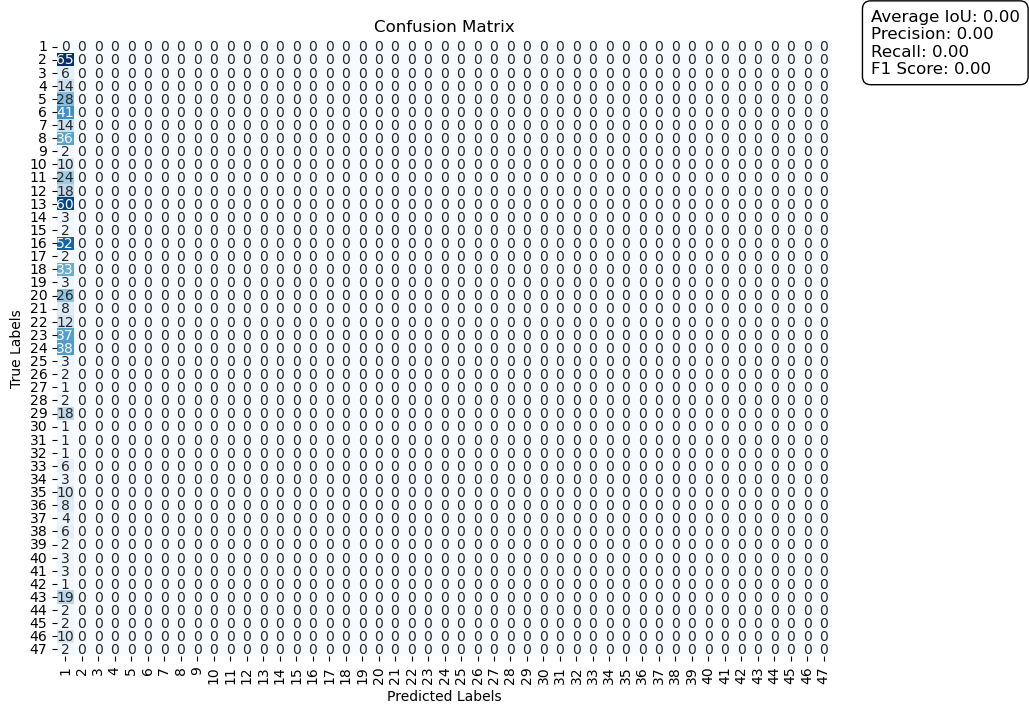

In [14]:
def plot_confusion_matrix(conf_matrix, class_names, metrics):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    
    metrics_text = (
        f"Average IoU: {metrics['avg_iou']:.2f}\n"
        f"Precision: {metrics['precision']:.2f}\n"
        f"Recall: {metrics['recall']:.2f}\n"
        f"F1 Score: {metrics['f1_score']:.2f}"
    )
    
    plt.gca().text(1.05, 1.05, metrics_text, transform=plt.gca().transAxes,
                   fontsize=12, verticalalignment='top',
                   bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    
    plt.show()

class_names = [f"{i + 1}" for i in range(len(metrics['confusion_matrix']))]
plot_confusion_matrix(metrics['confusion_matrix'], class_names, metrics)

### HOUGH TRANSFORM

In [15]:
def HoughTransform(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (9, 9), 2)
    
    circles = cv2.HoughCircles(
        blurred, 
        cv2.HOUGH_GRADIENT, 
        dp=1.2,       
        minDist=4,   
        param1=50,    
        param2=30,    
        minRadius=4, 
        maxRadius=50 
    )
    
    output_image = np.zeros_like(gray)
    
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            cv2.circle(output_image, (i[0], i[1]), i[2], (255), 2)
    
    return output_image

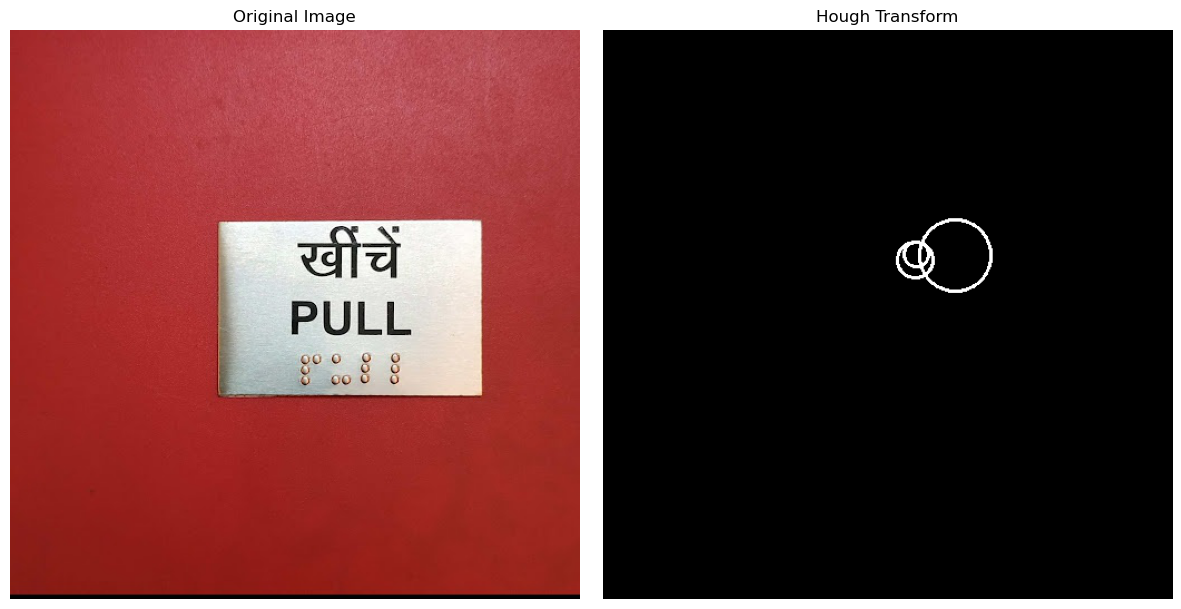

In [16]:
"""
TEST HOUGH TRANSFORM
"""

hough_test_image = './data-yolo/AF1QipOkgsneVSdYeba5vP16itZ79s642g-nPfsEr4h_0_0.jpg'

def test_hough_transform(image_path):
    hough_test_image = cv2.imread(image_path)

    transformed_image = HoughTransform(hough_test_image)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(hough_test_image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(transformed_image, cmap='gray')
    plt.title("Hough Transform")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
    
test_hough_transform(hough_test_image)

### TEXT SPOTTING MODEL

In [17]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
class UpConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out, scale_factor=4):
        super().__init__()
        self.up = nn.Sequential(
                                nn.Upsample(scale_factor=scale_factor),
                                nn.Conv2d(ch_in, ch_out,
                                         kernel_size=3,stride=1,
                                         padding=1, bias=True),
                                nn.BatchNorm2d(ch_out),
                                nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        x = x = self.up(x)
        return x

In [19]:
"""
Testing Models:
"""

def test_backbone(model, batch_size=16, imgsz=256):
    torch.cuda.empty_cache()
    model.to(device)
    image_tensor = torch.randn(batch_size, 3, imgsz, imgsz).to(device)
    output = model(image_tensor)
    print("Output shape:", output.shape)

class Backbone(nn.Module):
    """
    YOLO Backbone:
    
    output feature map: (batch_size, 3, 256, 256)
    """
    def __init__(self):
        super(Backbone, self).__init__()
        self.backbone = torch.hub.load("ultralytics/yolov5", "yolov5s").to(device)
        self.grid_size = 256
        
        self.conv1 = nn.Conv1d(4032, 512, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(512, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(128, 3, kernel_size=3, stride=1, padding=1)
        
        self.upsample1 = UpConvBlock(ch_in=3, ch_out=3)
        self.upsample2 = UpConvBlock(ch_in=3, ch_out=3)
        self.upsample3 = UpConvBlock(ch_in=3, ch_out=3, scale_factor=2)
        
        self._freeze_layers()
        
        
    def _freeze_layers(self):
        """
        Freezing the Backbone (except the last layer)
        """
        freeze = [f"model.{x}." for x in range(24)]
        for k, v in self.backbone.named_parameters():
            v.requires_grad = True
            if any(x in k for x in freeze):
                v.requires_grad = False
    
    def forward(self, x):
        """
        Creates an interface for the Backbone
        with output grid size: (batch_size, 3, self.grid_size, self.grid_size)
        """
        backbone_out = self.backbone.model.forward(x) # (batch_size, 4032, 85)
        
        l1 = self.conv1(backbone_out)  # (batch_size, 512, 85)
        l2 = self.conv2(l1)  # (batch_size, 128, 85)
        l3 = self.conv3(l2)  # (batch_size, 3, 85)
        
        l3 = l3.unsqueeze(-1)  # (batch_size, 3, 85, 1)
        
        l4 = self.upsample1(l3) # (batch_size, 3, 340, 4)
        l5 = self.upsample2(l4) # (batch_size, 3, 1360, 16)
        l6 = self.upsample3(l5) # (batch_size, 3, 2720, 32)
        
        out = torch.nn.functional.interpolate(l6, size=(self.grid_size, self.grid_size), mode='bilinear', align_corners=False)
        return out # (batch_size, 3, 256, 256)
    
"""
TEST
"""
test_backbone(Backbone())

Using cache found in /home/zeenx1popos/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-11-9 Python-3.12.2 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5931MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Output shape: torch.Size([16, 3, 256, 256])


In [20]:
"""
Testing Models:
"""

def test_retention(model, x1_channels=512, x2_channels=512, batch_size=16, imgsz=20):
    torch.cuda.empty_cache()
    model.to(device)
    layer1 = torch.randn(batch_size, x1_channels, imgsz, imgsz).to(device)
    layer2 = torch.randn(batch_size, x2_channels, imgsz, imgsz).to(device)
    output = model(layer1, layer2)
    print("Output shape:", output.shape)


class RetentionLayer(nn.Module):
    def __init__(self, x1_channels, x2_channels, out_channels):
        super(RetentionLayer, self).__init__()
        self.seq1 = nn.Sequential(
            nn.Conv2d(
                in_channels=x1_channels,
                out_channels=out_channels,
                kernel_size=1,
                stride=1,
                bias=True,
            ),
            nn.BatchNorm2d(out_channels)
        )
        self.seq2 = nn.Sequential(
            nn.Conv2d(
                in_channels=x2_channels,
                out_channels=out_channels,
                kernel_size=1,
                stride=1,
                bias=True,
            ),
            nn.BatchNorm2d(out_channels)
        )
        self.relu = nn.ReLU(inplace=True)
        self.attention = nn.Sequential(
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=1,
                kernel_size=1,
                stride=1,
                bias=True,
            ),
            nn.BatchNorm2d(1),
            nn.Sigmoid(),
        )
        
    def forward(self, X1, X2):
        x1 = self.seq1(X1)
        x2 = self.seq2(X2)
        S = self.relu(x1 + x2)
        S = self.attention(S)
        return X1 * S

"""
TEST
"""
test_retention(RetentionLayer(512, 512, 256))

        

Output shape: torch.Size([16, 512, 20, 20])


In [26]:
"""
Testing Models:
"""

def test_HoughModule(model, batch_size=16, imgsz=512):
    torch.cuda.empty_cache()
    model.to(device)
    layer1 = torch.randn(batch_size, 1, imgsz, imgsz).to(device)
    output = model(layer1)
    print("Output shape:", output.shape)

class HoughModule(nn.Module):
    def __init__(self):
        super(HoughModule, self).__init__()
        self.seq1 = nn.Sequential(
            nn.Conv2d(in_channels=1,
                      out_channels=3,
                      kernel_size=3,
                      padding=1),
            nn.Conv2d(in_channels=3,
                      out_channels=3,
                      kernel_size=1),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, image):
        transformed_image = image
        # transformed_image = HoughTransform(image)
        out = self.seq1(transformed_image)
        return out
    

"""
TEST
"""

test_HoughModule(HoughModule())

Output shape: torch.Size([16, 3, 512, 512])


In [27]:
class PredictBlock(nn.Module):
    def __init__(self) -> None:
        super(PredictBlock, self).__init__()
        
    def forward(x, img):
        return x